# ✈️✈️✈️ End-to-end Multi-class Military Aircraft Detection Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2 Object Detection API to train an SSD-MobileNet model or EfficientDet model with a custom dataset and convert it to TensorFlow Lite format.

Proceedure Roadmap:
When multiple annotated subjects in a single image, I am dealing with a multi-object detection problem. Here's a general approach to prepare the dataset for train split testing:

* Annotation: Each individual object in an image should be labeled separately. You'll want to create "bounding boxes" around each object in an image, and then label that box with the type of aircraft it contains. Tools like Labelbox, LabelImg, or VGG Image Annotator (VIA) can help with this process.

* Format the Data: Your labels should include not only the type of aircraft, but also the location of the bounding box within the image. These labels are usually saved in a structured format such as XML or JSON. For example, in TensorFlow's Object Detection API, they use the TFRecord format.

* Model Selection: You'll want to choose a model architecture that's designed for object detection. Some examples include Single Shot MultiBox Detector (SSD), Region-CNN (R-CNN), and You Only Look Once (YOLO).

* Training: When you train your model, it will learn to not only classify different types of aircraft but also to predict the bounding boxes around them in the image.

* Evaluation: Finally, you'll want to choose an appropriate evaluation metric. For multi-object detection tasks, mean Average Precision (mAP) is often used.

## 1. Problem

Identifying the type of airplain given an image of a aircraft.

When I take a photo of an airplane, I want to know what types of airplain and the number of airplane is in the photo.

## 2. Data

The data we're using is from Kaggle's "Military Aircraft Detection Dataset"

https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset

## 3. Evaluation

The evaluation is a file with prediction probobilities for each aircraft of each test image.

## 4. Dataset Features

* The dataset contain images with multiple and corrispnding labeling .csv files with the same file names.
* Each fragmented labeling csv file has precised x & y axis of value that can be used as the 4 corners bounding boxes for designated training areas for machines to learn.
* We are annotating the image samples with the provided xy axieses on each of the corrisponding labels (csv).
* There are 43 types of aircrafts (classes) for machine to learn.
* There are 10k+ samples total for further train-split-test modeling.

## 2. Install TensorFlow Object Detection Dependencies

First, we'll install the TensorFlow Object Detection API in this Google Colab instance. This requires cloning the [TensorFlow models repository](https://github.com/tensorflow/models) and running a couple installation commands. Click the play button to run the following sections of code.


In [ ]:
# Clone the tensorflow models repository from GitHub
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3914, done.
remote: Counting objects: 100% (3914/3914), done.
remote: Compressing objects: 100% (3022/3022), done.
remote: Total 3914 (delta 1131), reused 2013 (delta 839), pack-reused 0
Receiving objects: 100% (3914/3914), 49.65 MiB | 10.67 MiB/s, done.
Resolving deltas: 100% (1131/1131), done.


In [ ]:
# Copy setup files into models/research folder
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
#cp object_detection/packages/tf2/setup.py .

In [ ]:
# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# Modify setup.py file to install the tf-models-official repository targeted at TF v2.8.0
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/models/research/setup.py', 'w') as f:
    # Set fine_tune_checkpoint path
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [ ]:
# Install the Object Detection API
!pip install /content/models/research/

# Need to downgrade to TF v2.8.0 due to Colab compatibility bug with TF v2.10 (as of 10/03/22)
!pip install tensorflow==2.8.0

Processing ./models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 24.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 58.1 MB/s et

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 49.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.1
    Uninstalling tensorflow-2.8.1:
      Successfully uninstalled tensorflow-2.8.1


Let's test our installation by running `model_builder_tf2_test.py` to make sure everything is working as expected. Run the following code block and confirm that it finishes without errors. If you get errors, try Googling them or checking the FAQ at the end of this Colab.

In [ ]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10u

### Image and Labeling Data prep work
I want to test out the labeling data with the corresponding file name and place bounding boxes as preview to check for the authenticity. The following info is added to the image dataset:

* bounding boxes
* `class` labeling value added to the bounding boxes

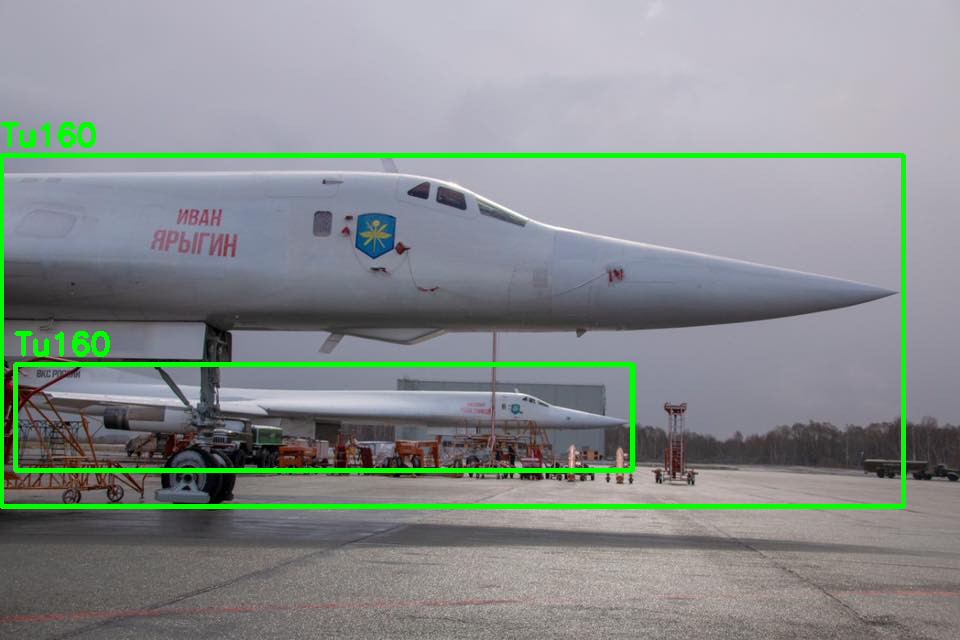

In [ ]:
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow

# Filter the rows related to the image
df_img = df_testing[df_testing['filename'] == '0a2a11a8658d69b6cd1fd23c5f4513bd']

# Read the image once
image_path = 'drive/MyDrive/Military Aircraft Recognition/0a2a11a8658d69b6cd1fd23c5f4513bd.jpg'
image = cv2.imread(image_path)

# Check if the image is correctly loaded
if image is None:
    print(f"No image found at {image_path}")
else:
    # Loop through each row in the filtered dataframe
    for index, row in df_img.iterrows():
        # Get the bounding box coordinates
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])

        # Get the class label
        label = str(row['class'])

        # Draw the bounding box and the label on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        cv2.putText(image, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    # Display the image with all bounding boxes
    cv2_imshow(image)

### Labeling DataSet Prep work

I need to concatenate all the labeling CSV files from scattered pieces into one unified labeling dataset as "Combined.csv".

In [ ]:
import os

# specify the directory you're starting from
rootDir = 'drive/MyDrive/Military Aircraft Recognition'

# create an empty list to store all dataframes
all_dfs = []

# iterate through all files in the directory
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        # check if the file is a csv file
        if fname.endswith('.csv'):
            # create a dataframe from the csv file and append it to the list
            df = pd.read_csv(os.path.join(dirName, fname))
            all_dfs.append(df)

# concatenate all dataframes in the list
combined_df = pd.concat(all_dfs, ignore_index=True)

# save the combined dataframe to a csv file
combined_df.to_csv(os.path.join(rootDir, 'combined.csv'), index=False)

combined_df.head

In [ ]:
# Drop all scattered labeling datasets leaving only the combined labeling dataset
directory = 'drive/MyDrive/Military Aircraft Recognition'

for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename != "combined.csv":
        os.remove(os.path.join(directory, filename))

### Apply the `Combined.csv` dataset for the image annotation labeling to all images samples

I want to use the combined.csv labeling dataset as the annotation bounding box under the "xmin, xmax, ymin, ymax" columns, and column "class" for labeling next to the bounding boxes for all the images dataset inside the same directory. Here is the following code so far:

In [ ]:
# Read the CSV file
df_testing = pd.read_csv('drive/MyDrive/Military Aircraft Recognition/combined.csv')

df_testing.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
18519,0a36e5862664eb92575949fc3ce7f842,900,600,Mig31,441,291,753,370
18520,b6b6185ac1d0e018eb35bc8a02ca9873,1752,986,F117,667,227,905,451
18521,313d6f38ab74d109dddb5efd382aeacb,1000,563,C2,453,210,896,376
18522,059843e8192d9e4e990da370775e1b53,1600,900,F18,213,200,576,463
18523,6d761316b0a4b33dab3ebcf386f5f184,7360,4912,E2,2448,1605,4779,3179


<Axes: >

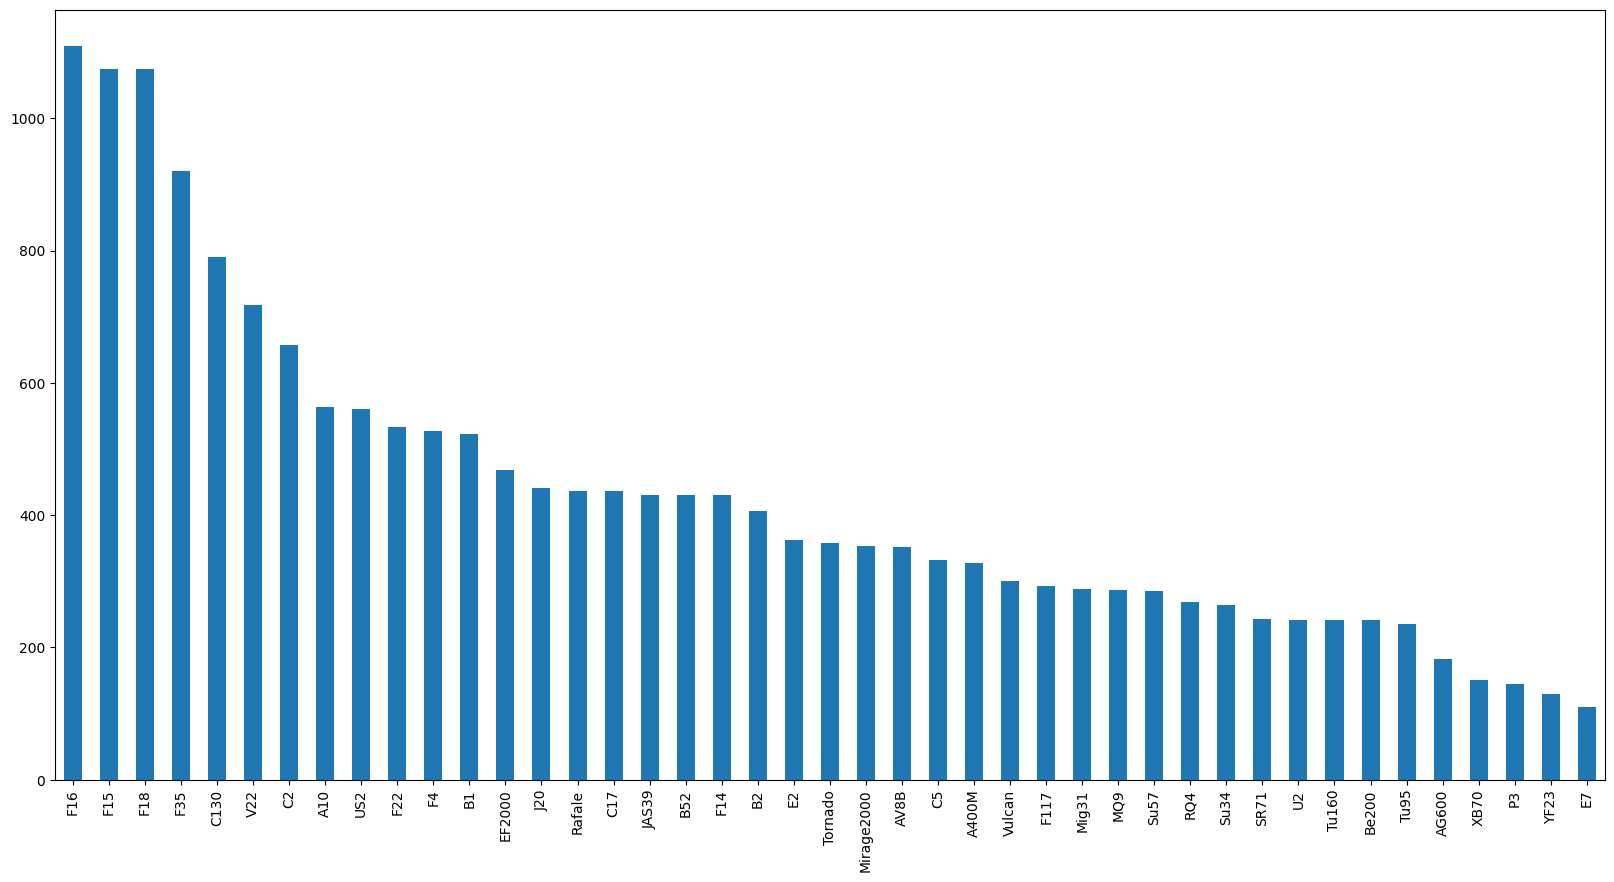

In [ ]:
# How many images are there of each class?
df_testing["class"].value_counts().plot.bar(figsize=(20, 10))

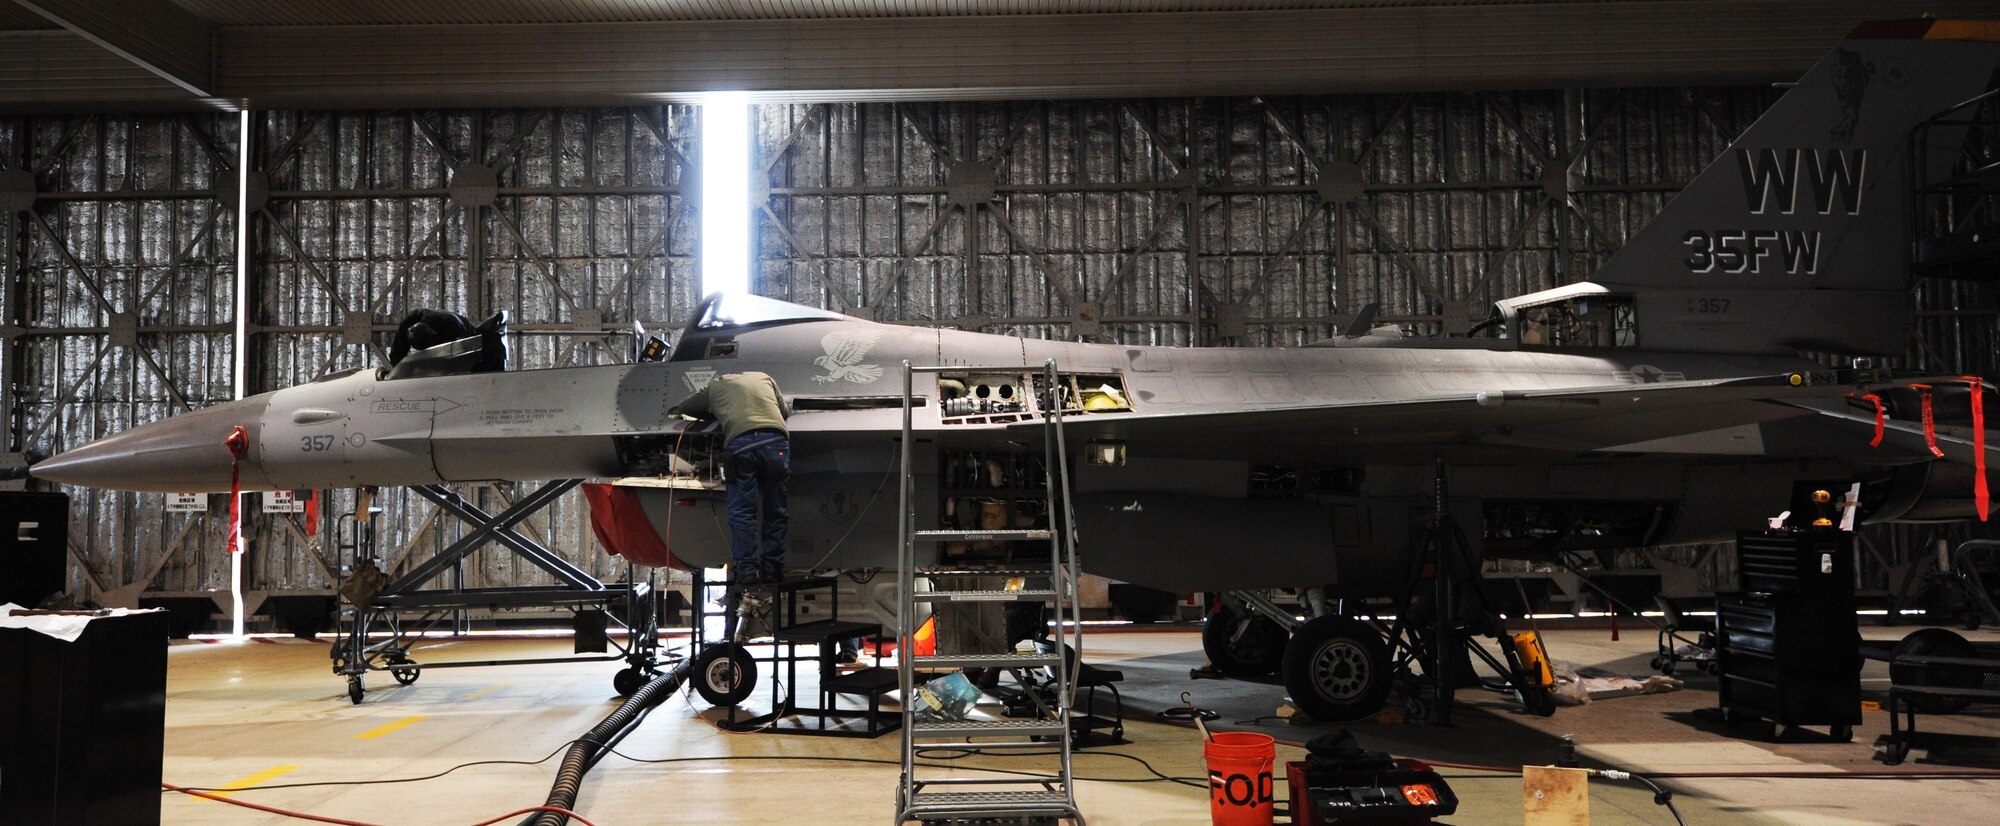

In [ ]:
# let's view an image
from IPython.display import Image
Image('drive/MyDrive/Military Aircraft Recognition/82265f597e80518a4554b0938783d2df.jpg')

Make sure the number of the image samples is correct in the directory

In [40]:
# Specify the directory
dir_path = 'drive/MyDrive/Military Aircraft Recognition'

# Get a list of all files and directories in the specified directory
files = os.listdir(dir_path)

# Use a list comprehension to filter out directories, leaving only files
files = [f for f in files if os.path.isfile(os.path.join(dir_path, f))]

# Print the number of files
print(len(files))

10980


In [ ]:
# Read the CSV file
df_testing = pd.read_csv('drive/MyDrive/Military Aircraft Recognition/combined.csv')

# Filter rows where 'filename' column contains the string '0a2a11a8658d69b6cd1fd23c5f4513bd'
df_filtered = df_testing[df_testing['filename'] == '0a2a11a8658d69b6cd1fd23c5f4513bd']

# Display the filtered DataFrame
print(df_filtered)

                               filename  width  height  class  xmin  ymin  \
15467  0a2a11a8658d69b6cd1fd23c5f4513bd    960     640  Tu160     1   155   
15468  0a2a11a8658d69b6cd1fd23c5f4513bd    960     640  Tu160    15   364   

       xmax  ymax  
15467   903   506  
15468   632   470  


### Try to access the combined dataset labels with rows corresponding to the image sample

### lets try to do the same for the first 5 sample rows according to the label dataset

In [ ]:
# Assuming you have a dataframe df_combined
unique_filenames = df_testing['filename'].unique()

# Process only the first 5 unique images
for filename in unique_filenames[:5]:
    df_img = df_testing[df_testing['filename'] == filename]

    # Read the image once
    image_path = f'drive/MyDrive/Military Aircraft Recognition/{filename}.jpg'
    image = cv2.imread(image_path)

    # Check if the image is correctly loaded
    if image is None:
        print(f"No image found at {image_path}")
        continue

    # Loop through each row in the filtered dataframe
    for index, row in df_img.iterrows():
        # Get the bounding box coordinates
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])

        # Get the class label
        label = str(row['class'])

        # Draw the bounding box and the label on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        cv2.putText(image, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    # Display the image with all bounding boxes
    cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.